In [1]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from qdax.core.containers.mome_repertoire import MOMERepertoire
from qdax import environments
from qdax.core.neuroevolution.networks.networks import MLP
import os
from typing import Tuple
from qdax.types import RNGKey
from IPython.display import HTML
from brax.io import html
from jax.flatten_util import ravel_pytree
from brax.io.file import File
from qdax.utils.plotting import plot_mome_pareto_fronts
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Define environment and network parameters
policy_hidden_layer_sizes = (64, 64)
episode_length = 1000
env_name = "kicker_exp_multi"
fixed_init_state = False
mutation_ga_batch_size = 256
mutation_qpg_batch_size = 64
num_objective_functions = 2
num_centroids = 256
pareto_front_max_length = 20
batch_size = mutation_ga_batch_size + mutation_qpg_batch_size * num_objective_functions
minval = 0
maxval = 1

location = '(0.7, 0.7)'
env = environments.create(env_name, episode_length=episode_length, fixed_init_state=fixed_init_state)

# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/final/repertoire/"
# save_dir = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/loaded_solutions/"
# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/final/repertoire/"
# save_dir = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/loaded_solutions/"
# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-19_143755_42/final/repertoire/"
# save_dir = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-19_143755_42/loaded_solutions/"
# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/average_rs_2.0_dt_0.02/final/repertoire/"
# save_dir = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/average_rs_2.0_dt_0.02/loaded_solutions/"
repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_exp_multi/mome_pgx/2024-08-03_111435_42/final/repertoire/"
save_dir = f"/home/coder/project/MOME_PGX/results/kicker_exp_multi/mome_pgx/2024-08-03_111435_42/loaded_solutions/{location}"


os.makedirs(save_dir, exist_ok=True)


In [3]:

# Visualisation function
def visualise_individual(env, policy_network, params, name, save_dir):
    path = os.path.join(save_dir, name)
    metrics_path = os.path.join(save_dir, f"{name}_metrics.json")
    contact_path = os.path.join(save_dir, f"{name}_contact_steps.json")

    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(policy_network.apply)

    rollout = []
    metrics_list = []
    angles = []
    ratios = []
    contact = []
    rng = jax.random.PRNGKey(seed=1)
    state = jit_env_reset(rng=rng)
    def ratio(x):
        ratio_1 = (x[0] + 1.0472)/2.0944
        ratio_2 =(x[1] - 0.349066)/1.5708
        return np.array([ratio_1, ratio_2])
    joint_limits = env.sys.joints[0].limit[0]
    # print(joint_limits)
    while not state.done:
        rollout.append(state)
        action = jit_inference_fn(params, state.obs)
        state = jit_env_step(state, action)
        metrics_list.append({
            "reward_dist": float(state.metrics["reward_dist"]),
            "reward_ctrl": float(state.metrics["reward_ctrl"]),
        })
        if np.any(state.info["angles"] != 0):
            ratio_ = ratio(state.info["angles"])
        else:
            ratio_ =np.array([0.0, 0.0])
        # print(state.info["angles"])
        # print(ratio_)
        angles.append(state.info["angles"])
        ratios.append(ratio_)
                
    s = np.sum(ratios, axis=0)
    # print(s)
    print(state.info["contact_timesteps"])

    contact.append({
        "contact": int(state.info["contact_timesteps"])
    })

    with File(path, 'w') as fout:
        fout.write(html.render(env.sys, [s.qp for s in rollout], height=480))

    with open(metrics_path, 'w') as fout:
        json.dump(metrics_list, fout, indent=4)

    with open(contact_path, 'w') as fout:
        json.dump(contact, fout, indent=4)

# Plotting function for metrics
def plot_metrics_from_json(json_path, save_dir):
    with open(json_path, 'r') as f:
        metrics = json.load(f)

    timesteps = list(range(len(metrics)))
    reward_dist = [m['reward_dist'] for m in metrics]
    reward_ctrl = [m['reward_ctrl'] for m in metrics]

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, reward_dist, label='Reward Dist')
    plt.plot(timesteps, reward_ctrl, label='Reward Ctrl')
    plt.xlabel('Timesteps')
    plt.ylabel('Reward')
    plt.title('Reward Metrics Over Time')
    plt.legend()
    plt_path = os.path.join(save_dir, os.path.basename(json_path).replace('.json', '.pdf'))
    plt.savefig(plt_path)
    plt.close()

# Plotting function for fitness
def plot_fitness_from_json(json_path, save_dir):
    with open(json_path, 'r') as f:
        metrics = json.load(f)

    timesteps = list(range(len(metrics)))
    fitness_dist = []
    fitness_ctrl = []
    cumulative_dist = 0
    cumulative_ctrl = 0

    for m in metrics:
        cumulative_dist += m['reward_dist']
        cumulative_ctrl += m['reward_ctrl']
        fitness_dist.append(cumulative_dist)
        fitness_ctrl.append(cumulative_ctrl)
    
    print(cumulative_dist, cumulative_ctrl)

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, fitness_dist, label='Reward Dist')
    plt.plot(timesteps, fitness_ctrl, label='Reward Ctrl')
    plt.xlabel('Timesteps')
    plt.ylabel('Fitness')
    plt.title('Fitnesses Over Time')
    plt.legend()
    plt_path = os.path.join(save_dir, 'fitnesses.pdf')
    plt.savefig(plt_path)
    plt.close()

def get_solutions_from_cell(repertoire, cell_index):
    genotypes = jax.tree_util.tree_map(lambda x: x[cell_index], repertoire.genotypes)
    fitnesses = repertoire.fitnesses[cell_index]
    return genotypes, fitnesses

In [4]:
# Create environment and policy network
random_key = jax.random.PRNGKey(42)
random_key, subkey = jax.random.split(random_key)
env = environments.create(env_name, episode_length=episode_length)
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)
random_key, subkey = jax.random.split(random_key)

keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_genotypes = jax.vmap(policy_network.init)(keys, fake_batch)

default_genotypes = jax.tree_util.tree_map(
    lambda x: jnp.zeros(
        shape=(
            num_centroids,
            pareto_front_max_length,
        )
        + x.shape[1:]
    ),
    init_genotypes,
)

global_unravel_fn = None

def flatten(genotype):
    global global_unravel_fn
    flatten_genotype, unravel_fn = ravel_pytree(genotype)
    if global_unravel_fn is None:
        global_unravel_fn = unravel_fn
    return flatten_genotype
flat_genotypes = jax.vmap(flatten)(default_genotypes)

# Load the repertoire
repertoire = MOMERepertoire.load(reconstruction_fn=global_unravel_fn, path=repertoire_path)

# Function to get a specific solution from a specific cell
def get_solution_from_cell(repertoire, cell_index, solution_index):
    genotypes = jax.tree_util.tree_map(lambda x: x[cell_index], repertoire.genotypes)
    return jax.tree_util.tree_map(lambda x: x[solution_index], genotypes)
    
def get_descriptors_from_solution(repertoire, cell_index, solution_index):
    desc = jax.tree_util.tree_map(lambda x: x[cell_index], repertoire.descriptors)
    return jax.tree_util.tree_map(lambda x: x[solution_index], desc)
    
def get_fitnesses_from_solution(repertoire, cell_index, solution_index):
    fit = jax.tree_util.tree_map(lambda x: x[cell_index], repertoire.fitnesses)
    return jax.tree_util.tree_map(lambda x: x[solution_index], fit)

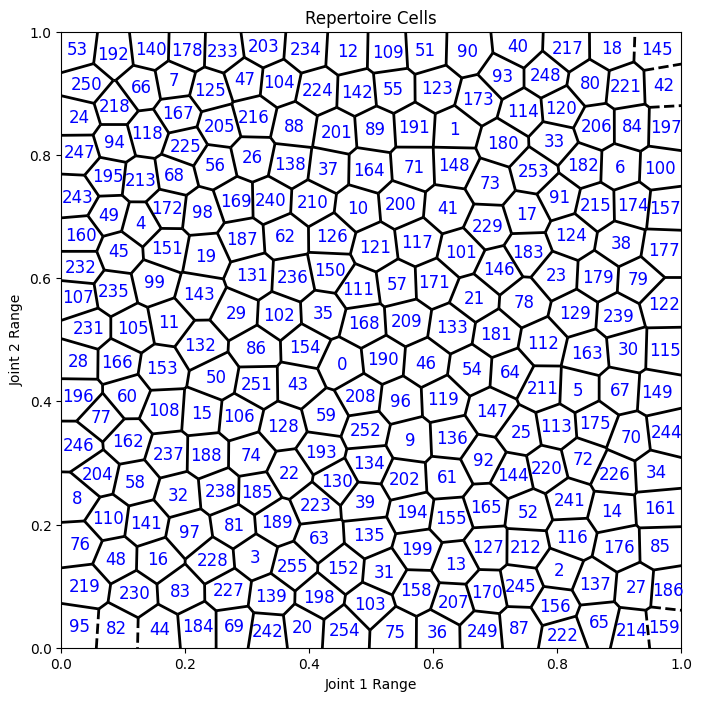

In [5]:
# Load centroids
centroids = jnp.array(repertoire.centroids)

vor = Voronoi(centroids)

fig, ax = plt.subplots(figsize=(8, 8))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=2, point_size=0)

for idx, point in enumerate(centroids):
    ax.text(point[0], point[1], str(idx), color='blue', fontsize=12, ha='center', va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.xlabel("Joint 1 Range")
plt.ylabel("Joint 2 Range")
plt.title("Repertoire Cells")
plt.show()

In [6]:
cell_number = int(input("Enter the cell number you want to inspect: "))

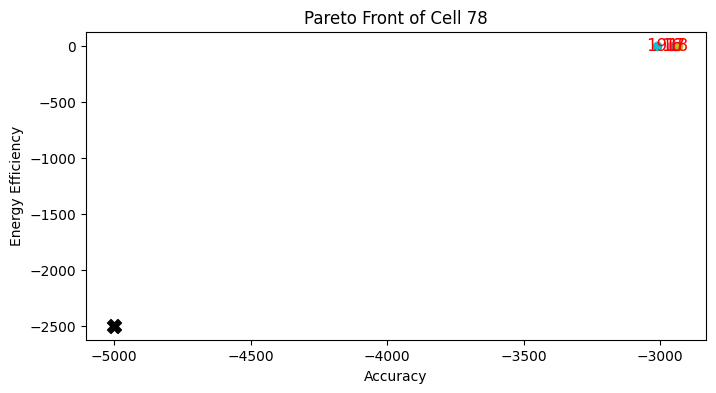

In [7]:
cell_genotypes, cell_fitnesses = get_solutions_from_cell(repertoire, cell_number)
reference_point = [-5000, -2500]
fig, ax = plt.subplots(figsize=(8, 4))
for idx, fitness in enumerate(cell_fitnesses):
    ax.scatter(fitness[0], fitness[1], label=f'Solution {idx}')
    ax.text(fitness[0], fitness[1], str(idx), color='red', fontsize=12, ha='center', va='center')

ax.scatter(reference_point[0], reference_point[1], color='black', s=100, marker='X', label='Reference Point')

plt.xlabel("Accuracy")
plt.ylabel("Energy Efficiency")
plt.title(f"Pareto Front of Cell {cell_number}")
plt.show()

In [8]:
# User input for solution number
solution_number = int(input("Enter the solution number you want to visualize: "))

# Retrieve the chosen solution
params = jax.tree_util.tree_map(lambda x: x[solution_number], cell_genotypes)

# Visualize the chosen solution
file_name = f"solution_from_cell_{cell_number}_{solution_number}.html"
visualise_individual(env, policy_network, params, file_name, save_dir)

json_path = os.path.join(save_dir, f"{file_name}_metrics.json")
plot_metrics_from_json(json_path, save_dir)
plot_fitness_from_json(json_path, save_dir)

61.0
-2935.689648628235 -0.19014646977757366
